In [1]:
import torchvision
import torch
from pipeline import Pipeline
from omegaconf import OmegaConf
from ml_collections import ConfigDict
import argparse
import PIL
from tensorflow.io import gfile
import time
import os
import warnings
import numpy as np

from vae.config.bedroom import get_config as bedroom_config
from vae.config.church import get_config as church_config
from vae.config.imagenet256_kl8 import get_config as imagenet_config


c:\Users\gabri\anaconda3\envs\brain-decoding\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
from PIL import Image
import torch.nn as nn
# from .nn import Conv2D

In [3]:
INFO = {
    "bedroom": ConfigDict({
        "dae_config": "dae/config/bedroom.yaml",
        "vae_config": bedroom_config(),
        "weights_name": "./models/bedroom_pipeline.pt",
        "weights_id": "1--uqW9S8-tbMJG8whHDx1qPJeH5W0j9r",
    }),
    "church": ConfigDict({
        "dae_config": "dae/config/church.yaml",
        "vae_config": church_config(),
        "weights_name": "./models/church_pipeline.pt",
        "weights_id": "1-174o5MywJYhhOcYI6yzMfUP5DvnlPcK",
    }),
    "imagenet": ConfigDict({
        "dae_config": "dae/config/imagenet.yaml",
        "vae_config": imagenet_config(),
        "weights_name": "./models/inet_pipeline.pt",
        "weights_id": "1-Td-danBSRX4IhlXAD_CtgFARbu4C9hH",
    }),
}

In [22]:
img_ndx = 0
label = 1
n_sample = 1
dae_batchsize = 1

In [5]:
model_name = "imagenet"
config = INFO[model_name]

vae_config = config.vae_config
dae_config = OmegaConf.load(config.dae_config)["model"]
pipe = Pipeline(vae_config, dae_config)
if torch.cuda.is_available():
    print('cuda')
    pipe = pipe.to('cuda')

making attention of type 'vanilla' with 512 in_channels
Working with z of shape (1, 4, 32, 32) = 4096 dimensions.
making attention of type 'vanilla' with 512 in_channels


c:\Users\gabri\anaconda3\envs\brain-decoding\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\gabri\anaconda3\envs\brain-decoding\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


loaded pretrained LPIPS loss from taming/modules/autoencoder/lpips\vgg.pth
cuda


In [6]:
pipe.load_from_ckpt(config.weights_name)

In [7]:
pipe.vae.num_classes

1000

In [26]:
if pipe.vae.num_classes:
    device = next(pipe.parameters()).device
    if label is None:
        label = torch.randint(size=[n_sample], low=0, high=pipe.vae.num_classes).to(device)
    else:
        label = (torch.ones([n_sample]) * int(label)).int().to(device)  

In [27]:
print(label)

tensor([1], device='cuda:0', dtype=torch.int32)


In [22]:
images = np.load('data/nsd_test_stim_sub1.npy').astype(np.uint8)

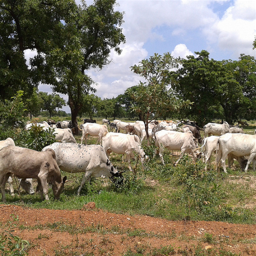

In [23]:
pil_img = Image.fromarray(images[img_ndx]).resize((256,256))
pil_img

(256, 256)


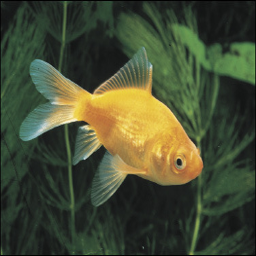

In [23]:
pil_img = Image.open('data/n01443537_goldfish.JPEG').resize((256,256))
print(pil_img.size)
pil_img

In [12]:
img_list = [pil_img]
img = np.stack([np.array(img) for img in img_list], axis=0)
img = img / 255.0 
img = torch.from_numpy(img).float().permute(0,3,1,2)
img = 2 * (img - 0.5)
img.shape

torch.Size([1, 3, 256, 256])

In [24]:
latent_dist = pipe.dae.encode(img.to(device))
latent_samples = latent_dist.sample()
# latent_samples *= 0.18215 
latent_samples.shape

torch.Size([1, 4, 32, 32])

In [48]:
# test = latent_samples * pipe.vae_config.dataset.scale + pipe.vae_config.dataset.shift

In [360]:
# pipe.vae.cond = False

In [29]:
# test = pipe.vae.forward(latent_samples.to(device)) 


In [307]:
# def get_resolutions(max_res, num_res):
#     resos = []
#     current_res = max_res
#     for i in range(num_res):
#         if current_res<4: current_res = 1
#         resos.append(current_res)
#         current_res //= 2
#     return resos

# c = pipe.vae_config.model.c
# C = [c * mult for mult in pipe.vae_config.model.c_mult]
# print(C)
# print(C[-1])

# with torch.no_grad():
#     resolutions = get_resolutions(pipe.vae.resolution, len(pipe.vae.nlayers))
#     initial_x = nn.Parameter(torch.zeros([1, C[-1], resolutions[-1], resolutions[-1]]))

# embed = nn.Embedding(pipe.vae.num_classes+1, C[-1]).to(device)

In [14]:
uncond_label = torch.full_like(label, pipe.vae.num_classes).to(device)
mask = torch.greater(torch.rand(label.shape), 0.9).int().to(device)
cf_guidance_label = label*(1-mask) + mask*uncond_label

label = pipe.vae.embed(label).to(device)
cf_guidance_label = pipe.vae.embed(cf_guidance_label).to(device)
generator_label = (label, cf_guidance_label)
x = torch.tile(pipe.vae.initial_x, [img.shape[0], 1, 1, 1]).to(device)

In [374]:
print(label.shape, x.shape)
# x

torch.Size([1, 256, 1, 1])


In [15]:
with torch.no_grad():
    acts = pipe.vae.encoder.forward(latent_samples, label)
    KLs = []
    SR_Losses = 0.

In [16]:
for i in range(len(acts)):
    print(i, acts[i].shape, acts[i].dtype)

0 torch.Size([1, 384, 32, 32]) torch.float32
1 torch.Size([1, 384, 16, 16]) torch.float32
2 torch.Size([1, 384, 8, 8]) torch.float32
3 torch.Size([1, 384, 4, 4]) torch.float32
4 torch.Size([1, 384, 1, 1]) torch.float32


In [17]:
with torch.no_grad():
    for i, decoderlevel in enumerate(pipe.vae.layer_list):
        j = -i+len(pipe.vae.nlayers)-1
        x, kls, sr_losses = decoderlevel(x, acts[j], generator_label)
        KLs.extend(kls)
        SR_Losses += sr_losses

In [18]:
print(x.shape)
x

torch.Size([1, 256, 32, 32])


tensor([[[[nan, nan, nan,  ..., nan, nan, nan],
          [nan, nan, nan,  ..., nan, nan, nan],
          [nan, nan, nan,  ..., nan, nan, nan],
          ...,
          [nan, nan, nan,  ..., nan, nan, nan],
          [nan, nan, nan,  ..., nan, nan, nan],
          [nan, nan, nan,  ..., nan, nan, nan]],

         [[nan, nan, nan,  ..., nan, nan, nan],
          [nan, nan, nan,  ..., nan, nan, nan],
          [nan, nan, nan,  ..., nan, nan, nan],
          ...,
          [nan, nan, nan,  ..., nan, nan, nan],
          [nan, nan, nan,  ..., nan, nan, nan],
          [nan, nan, nan,  ..., nan, nan, nan]],

         [[nan, nan, nan,  ..., nan, nan, nan],
          [nan, nan, nan,  ..., nan, nan, nan],
          [nan, nan, nan,  ..., nan, nan, nan],
          ...,
          [nan, nan, nan,  ..., nan, nan, nan],
          [nan, nan, nan,  ..., nan, nan, nan],
          [nan, nan, nan,  ..., nan, nan, nan]],

         ...,

         [[nan, nan, nan,  ..., nan, nan, nan],
          [nan, nan, n

In [119]:
# def Conv2D(c_in, c_out, kernel_size, w_scale=1., strides=1, use_bias=True):
#     padding = kernel_size//2 #dimension preserving padding for all odd kernel sizes.
#     conv = nn.Conv2d(
#         c_in, c_out,
#         kernel_size=(kernel_size, kernel_size),
#         stride=(strides, strides),
#         bias=use_bias,
#         padding=padding
#     )
#     torch.nn.init.xavier_uniform_(conv.weight)
#     conv.weight.data.mul_(w_scale)
#     return conv

In [123]:
# outproj = Conv2D(C[0], pipe.vae.datadim * 2, 1).to(device)

In [278]:
x = pipe.vae.outproj(x)
latents = x[:, :pipe.vae.datadim, ...]
latents.shape

torch.Size([1, 4, 32, 32])

In [279]:
latents

tensor([[[[nan, nan, nan,  ..., nan, nan, nan],
          [nan, nan, nan,  ..., nan, nan, nan],
          [nan, nan, nan,  ..., nan, nan, nan],
          ...,
          [nan, nan, nan,  ..., nan, nan, nan],
          [nan, nan, nan,  ..., nan, nan, nan],
          [nan, nan, nan,  ..., nan, nan, nan]],

         [[nan, nan, nan,  ..., nan, nan, nan],
          [nan, nan, nan,  ..., nan, nan, nan],
          [nan, nan, nan,  ..., nan, nan, nan],
          ...,
          [nan, nan, nan,  ..., nan, nan, nan],
          [nan, nan, nan,  ..., nan, nan, nan],
          [nan, nan, nan,  ..., nan, nan, nan]],

         [[nan, nan, nan,  ..., nan, nan, nan],
          [nan, nan, nan,  ..., nan, nan, nan],
          [nan, nan, nan,  ..., nan, nan, nan],
          ...,
          [nan, nan, nan,  ..., nan, nan, nan],
          [nan, nan, nan,  ..., nan, nan, nan],
          [nan, nan, nan,  ..., nan, nan, nan]],

         [[nan, nan, nan,  ..., nan, nan, nan],
          [nan, nan, nan,  ..., nan, 

In [266]:
latents = (latents * pipe.vae_config.dataset.scale) + pipe.vae_config.dataset.shift
latents.shape

torch.Size([1, 4, 1, 1])

In [150]:
output_ims = []

for i in range(n_sample // dae_batchsize):
    lats = latents[i*dae_batchsize : i*dae_batchsize+dae_batchsize]
    ims = pipe.dae.decode(lats)
    ims = ims.float().cpu().permute(0, 2, 3, 1)
    output_ims.append(ims)

In [149]:
n_sample // dae_batchsize

1

In [129]:
output_ims = np.concatenate(tuple(output_ims), axis=0)
output_ims = output_ims * 0.5 + 0.5
output_ims = np.clip(output_ims, 0., 1.) * 255
output_ims = output_ims.astype('uint8')

ValueError: need at least one array to concatenate